## Important details of the first order formulation
This notebook here is to test the first order ODE solver

The main thing to worry about is the fact that we need to do some mode sorting in order to properly evaluate the eigenmodes for the $E$ and $H$ fields (so it matches with the 2nd order formulation, which automatically does 'mode sorting').

Beyond that, we should be able to extract both the $W$ and $V$ eigenmodes for the H and E field eigenmodes.

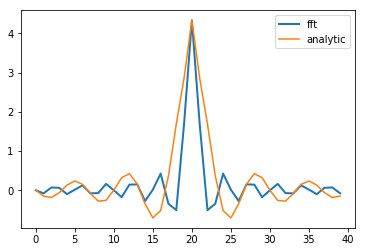

C:\Users\zhaon\Anaconda3\lib\site-packages\numpy\core\numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


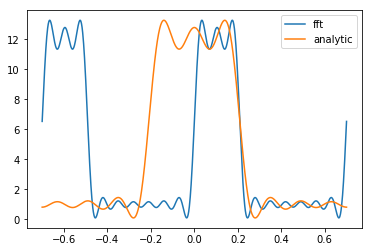

In [110]:
## same as the analytic case but with the fft
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import cond
import cmath;
from scipy.fftpack import fft, fftfreq, fftshift, rfft
from scipy.fftpack import dst, idst
from scipy.linalg import expm
from scipy import linalg as LA
import random

# Moharam et. al Formulation for stable and efficient implementation for RCWA
plt.close("all")
'''
1D TE implementation of PLANAR DIFFRACTiON...the easy case
only: sign convention is exp(-ikr) (is the positive propagating wave), so loss is +  not - 
source for fourier decomps is from the paper: Formulation for stable and efficient implementation of
the rigorous coupled-wave analysis of binary gratings by Moharam et. al
'''
np.set_printoptions(precision = 4)

def grating_fourier_harmonics(order, fill_factor, n_ridge, n_groove):
    """ function comes from analytic solution of a step function in a finite unit cell"""
    #n_ridge = index of refraction of ridge (should be dielectric)
    #n_ridge = index of refraction of groove (air)
    #n_ridge has fill_factor
    #n_groove has (1-fill_factor)
    # there is no lattice constant here, so it implicitly assumes that the lattice constant is 1...which is not good

    if(order == 0):
        return n_ridge**2*fill_factor + n_groove**2*(1-fill_factor);
    else:
        #should it be 1-fill_factor or fill_factor?, should be fill_factor
        return(n_ridge**2 - n_groove**2)*np.sin(np.pi*order*(fill_factor))/(np.pi*order);

def grating_fourier_array(num_ord, fill_factor, n_ridge, n_groove):
    """ what is a convolution in 1D """
    fourier_comps = list();
    for i in range(-num_ord, num_ord+1):
        fourier_comps.append(grating_fourier_harmonics(i, fill_factor, n_ridge, n_groove));
    return fourier_comps;

def fourier_reconstruction(x, period, num_ord, n_ridge, n_groove, fill_factor = 0.5):
    index = np.arange(-num_ord, num_ord+1);
    f = 0;
    for n in index:
        coef = grating_fourier_harmonics(n, fill_factor, n_ridge, n_groove);
        f+= coef*np.exp(cmath.sqrt(-1)*np.pi*n*x/period);
        #f+=coef*np.cos(np.pi*n*x/period)
    return f;

def fourier_reconstruction_general(x, period, num_ord, coefs):
    '''
    overloading odesn't work in python...fun fact, since it is dynamically typed (vs statically typed)
    :param x:
    :param period:
    :param num_ord:
    :param coefs:
    :return:
    '''
    index = np.arange(-num_ord, num_ord+1);
    f = 0; center = int(len(coefs)/2); #no offset
    for n in index:
        coef = coefs[center+n];
        f+= coef*np.exp(cmath.sqrt(-1)*2*np.pi*n*x/period);
    return f;

def grating_fft(eps_r):
    assert len(eps_r.shape) == 2
    assert eps_r.shape[1] == 1;
    #eps_r: discrete 1D grid of the epsilon profile of the structure
    fourier_comp = np.fft.fftshift(np.fft.fft(eps_r, axis = 0)/eps_r.shape[0]);
    #ortho norm in fft will do a 1/sqrt(n) scaling
    return np.squeeze(fourier_comp);

# plt.plot(x, np.real(fourier_reconstruction(x, period, 1000, 1,np.sqrt(12), fill_factor = 0.1)));
# plt.title('check that the analytic fourier series works')
# #'note that the lattice constant tells you the length of the ridge'
# plt.show()

L0 = 1e-6;
e0 = 8.854e-12;
mu0 = 4*np.pi*1e-8;
fill_factor = 0.3; # 50% of the unit cell is the ridge material


num_ord = 10; #INCREASING NUMBER OF ORDERS SEEMS TO CAUSE THIS THING TO FAIL, to many orders induce evanescence...particularly
               # when there is a small fill factor
PQ = 2*num_ord+1;
indices = np.arange(-num_ord, num_ord+1)

n_ridge = 3.48; #1-3.48j; #3.48;              # ridge
n_groove =  1;                # groove (unit-less)
lattice_constant = 0.7;  # SI units
# we need to be careful about what lattice constant means
# in the gaylord paper, lattice constant exactly means (0, L) is one unit cell


d = 0.46;               # thickness, SI units
Nx = 2*256;
eps_r = n_groove**2*np.ones((2*Nx, 1)); #put in a lot of points in eps_r
border = int(2*Nx*fill_factor);
eps_r[0:border] = n_ridge**2;
fft_fourier_array = grating_fft(eps_r);
x = np.linspace(-lattice_constant,lattice_constant,1000);
period = lattice_constant;
fft_reconstruct = fourier_reconstruction_general(x, period, num_ord, fft_fourier_array);

fourier_array_analytic = grating_fourier_array(Nx, fill_factor, n_ridge, n_groove);
analytic_reconstruct = fourier_reconstruction(x, period, num_ord, n_ridge, n_groove, fill_factor)


plt.figure();
plt.plot(np.real(fft_fourier_array[Nx-20:Nx+20]), linewidth=2)
plt.plot(np.real(fourier_array_analytic[Nx-20:Nx+20]));
plt.legend(('fft', 'analytic'))
plt.show()

plt.figure();
plt.plot(x,fft_reconstruct)
plt.plot(x,analytic_reconstruct);
plt.legend(['fft', 'analytic'])
plt.show()

## simulation parameters
theta = (0)*np.pi/180;


## construct permittivity harmonic components E
#fill factor = 0 is complete dielectric, 1 is air

##construct convolution matrix
E = np.zeros((2 * num_ord + 1, 2 * num_ord + 1)); E = E.astype('complex')
p0 = Nx; #int(Nx/2);
p_index = np.arange(-num_ord, num_ord + 1);
q_index = np.arange(-num_ord, num_ord + 1);
fourier_array = fft_fourier_array;#fourier_array_analytic;
detected_pffts = np.zeros_like(E);
for prow in range(2 * num_ord + 1):
    # first term locates z plane, 2nd locates y coumn, prow locates x
    row_index = p_index[prow];
    for pcol in range(2 * num_ord + 1):
        pfft = p_index[prow] - p_index[pcol];
        detected_pffts[prow, pcol] = pfft;
        E[prow, pcol] = fourier_array[p0 + pfft];  # fill conv matrix from top left to top right

## IMPORTANT TO NOTE: the indices for everything beyond this points are indexed from -num_ord to num_ord+1








##  Calculating the Poynting Vector of a Sum of Plane Waves
Each plane wave has a contributing amplitude. Do we sum all the plane waves then calculate the Poynting vector or can we sum the Poynting vectors of the individual waves? The issue is that a product of a sum is not the same as the sum of products. Presently, I've tried both. It only appears to work in the simple case of 0 orders (or just plane waves).

Technically, each plane has has a different propagation in $k_z$ indexed by their Fourier index, which means we cna't deal with the components by themselves, we'd have to add in their phase. We could also just set $z=0$ to avoid this nasty problem.

Secret Sauce: Obviously with the Fourier order decomposition in $x$, some of the fourier $k_{zi}$ components may be evanescent. These components should have no contribution to the Poynting vector (especially in the far-field).

### some debugging notes
the long wavelength case should be error-free because there is little scattering into higher diffraction orders... but it appears to be the opposite in our test case below. Mathematically, however, we can see it in the fact that we have $m_i \lambda$ when we determine our kx_array, which means larger wavelengths have larger contributions at higher orders, which is a weird sounding statement.

In the 2nd order, stable formulation, we simply have REAL eigenvalues (if the system is Hermitian). When we square root this, if we have a purely negative number, then doing the square root should still only yield a single sign in the imaginary part as well.

It is clear that solving the first order and second order eigenvalue problems lead to the same set of eigenvalues, but the choice selected by the second order problem seems weird. Specifically, while the real part is always consistently one sign (which means sorting would work), the imaginary part selection is not all the same sign, particularly the eigenvalues with effectively zero real $k$. The problem with this has been determined to be a numerical artifact (see below). One proposed solution is to zero out the real part if it's below numerical precision (but this feels very unsatisfactory)

Empirically, it seems that sorting the larger block eigenvalues FAILS period.

In our current code implementation, we have the X matrix as np.exp(-k_0 *Q *d). So we neg out everything. However, the fact that some of the imaginary parts flip sign doesn't mean this part is wrong.

In [111]:
## plot snippets
## plot verifies that all eigenvalues extracted by beigenvals matches with one in Q
#     plt.subplot(121)
#     for b in beigenvals:
#         plt.axhline(np.imag(b))
#     plt.plot(np.imag(np.diag(Q)),'.g-', markersize = 10)
#     plt.title(str((len(beigenvals), len(np.diag(Q)))))
#     plt.subplot(122)
#     for b in beigenvals:
#         plt.axhline(np.real(b))
#     plt.plot(np.real(np.diag(Q)),'.g-', markersize = 10)
#     plt.title('real')
#     plt.show()

## snippet to check maching square of eigenvals
#     for b in np.abs(np.square(beigenvals)):
# #         plt.axhline(b);

# #     plt.plot(sorted(np.abs(eigenvals)));
# #     plt.show();

In [120]:
## alternate construction of 1D convolution matrix
spectra = list();
spectra_T = list();
I = np.identity(2 * num_ord + 1)
PQ = 2*num_ord+1;
zeros = np.zeros((PQ, PQ))
# E is now the convolution of fourier amplitudes
wavelength_scan = np.linspace(0.5,2.3,300)

for wvlen in wavelength_scan:
    j = cmath.sqrt(-1);
    lam0 = wvlen;     k0 = 2 * np.pi / lam0; #free space wavelength in SI units
    print('wavelength: ' + str(wvlen));
    ## =====================STRUCTURE======================##

    ## Region I: reflected region (half space)
    n1 = 1;#cmath.sqrt(-1)*1e-12; #apparently small complex perturbations are bad in Region 1, these shouldn't be necessary

    ## Region 2; transmitted region
    n2 = 1;

    #from the kx_components given the indices and wvln
    kx_array = k0*(n1*np.sin(theta) + indices*(lam0 / lattice_constant)); #0 is one of them, k0*lam0 = 2*pi
    k_xi = kx_array;
    ## IMPLEMENT SCALING: these are the fourier orders of the x-direction decomposition.
    KX = np.diag(kx_array/k0);
    KX2 = np.diag(np.power((k_xi/k0),2)); #singular since we have a n=0, m= 0 order and incidence is normal
    #print(KX2)
    KZ2 = ((n1)**2 - np.diag(KX2)).astype('complex');
    KZ = np.sqrt(KZ2)
#     print('KZ2: '+str(KZ2)+': imag Kz: '+str(KZ))
#     KZ_mask = np.imag(KZ)<1e-2;
#     KZ_mask = np.expand_dims(KZ_mask, axis = 1)
#     print(KZ_mask.shape)
    
    ## construct matrix of Gamma^2 ('constant' term in ODE):
    A = KX2 - E; #conditioning of this matrix is not bad, A SHOULD BE SYMMETRIC
    #sum of a symmetric matrix and a diagonal matrix should be symmetric;
    AO = np.block([[zeros, I],[A, zeros]])
    beigenvals, bigW = LA.eig(AO);
    #print('conditioning of big block: '+str(np.linalg.cond(AO)))
    ## SORTING IS REQUIRED
    #sorting procedure is to order by smallest imaginary part to largest imaginary part
    # We actually have to calculate poynting vector (the modes are Ey, Hx) and Sz = -Ey*Hx
    # since we are dealing with a normalized H, we need to divide by 1/j;
    Ey_modes = bigW[0:PQ, :];
    Hx_modes = bigW[PQ:, :]
    

    EyAmp = np.sum(Ey_modes, axis = 0); #amplitude
    HxAmp = np.sum(Hx_modes, axis = 0);
    #EyAmp = np.sum(Ey_modes*KZ_mask, axis = 0); #amplitude
    #HxAmp = np.sum(Hx_modes*KZ_mask, axis = 0);
    
    ## right now it works for a uniform slab, any orders...which means it 
    Sz = (1/j)*EyAmp*(HxAmp);
#     print(Sz.shape)
    sorted_indices_poynting = np.argsort(Sz)
    sorted_indices = np.argsort(np.real(beigenvals))
    #print(Sz[sorted_indices])
    
    sorted_eigenmodes = bigW[:,sorted_indices ];
    #print(sorted_eigenmodes)
    #adding real and imaginary parts seems to work...
    sorted_eigenvals = beigenvals[sorted_indices]
    Wp = sorted_eigenmodes[0:PQ:,0:PQ]
    eigenvals_wp = (sorted_eigenvals[0:PQ]);
    #print('sorted beigenvals: '+str(sorted_eigenvals))
    #print('extracted eigenvals: '+str(eigenvals_wp))

    #print(eigenvals_wp.shape)
    #plt.plot(np.imag(sorted_eigenvals));
    #plt.show()
    ##
    # when we calculate eigenvals, how do we know the eigenvals correspond to each particular fourier order?
    eigenvals, W = LA.eig(A); #A should be symmetric or hermitian
    #print('sorted eigenvals: '+str(sorted(np.sqrt(eigenvals))))

#     plt.subplot(121);
#     plt.imshow(np.abs(W));
#     plt.subplot(122);
#     plt.imshow(np.abs(bigW));
#     plt.show()
    
    #W = Wp; 
    #V = sorted_eigenmodes[0:PQ, :]
    #we should be gauranteed that all eigenvals are REAL
    eigenvals = eigenvals.astype('complex');
    
    Q = np.diag(np.sqrt(eigenvals)); #Q should only be positive square root of eigenvals
    #real parts match, but the imaginaries don't
    #Q = np.diag(eigenvals_wp);
    #plt.plot(sorted(np.abs(beigenvals)),'.-');
#     colors = [(random.random(),random.random(),random.random()) for i in range(len(beigenvals))]
#     plt.subplot(131)
#     plt.plot(np.real(beigenvals), np.imag(beigenvals), '.'); plt.title('1st')
#     plt.ylim([-4,4])
#     plt.subplot(132)
#     plt.plot(np.real(np.diag(Qn)), np.imag(np.diag(Qn)), '.'); plt.title('2nd')
#     plt.ylim([-4,4])
#     plt.subplot(133);
#     plt.plot(np.real(np.sqrt(eigenvals)), np.imag(np.sqrt(eigenvals)), '.g'); plt.title('squared 2nd')
#     plt.ylim([-4,4])

    plt.show();
#     plt.subplot(121)
#     for b in beigenvals:
#         plt.axhline(np.imag(b), color='r')
#     for b in np.sqrt(eigenvals):
#         plt.axhline(np.imag(b))

#     plt.plot((np.imag(np.diag(Q))),'.g-', markersize = 10)
#     plt.plot((np.imag(np.diag(Qn))), '.c-', markersize = 10)
#     plt.title(str((len(beigenvals), len(np.diag(Q)))))
    
#     plt.subplot(122)
    
#     for b in beigenvals:
#         plt.axhline(np.real(b), color = 'r')
#     for b in np.sqrt(eigenvals):
#         plt.axhline(np.real(b))
        
#     plt.plot((np.real(np.diag(Q))),'.g-', markersize = 10)
#     plt.title('real')

#     plt.plot((np.real(np.diag(Qn))), '.c-')
#     plt.show()


    V = W@Q; #H modes

    ## THIS ENFORCES a PARTICULAR SIGN...
    X = np.diag(np.exp(-k0*np.diag(Q)*d)); #this is poorly conditioned because exponentiation
    ## pointwise exponentiation vs exponentiating a matrix

    ## observation: almost everything beyond this point is worse conditioned
    k_I = k0**2*(n1**2 - (k_xi/k0)**2);                 #k_z in reflected region k_I,zi
    k_II = k0**2*(n2**2 - (k_xi/k0)**2);   #k_z in transmitted region
    k_I = k_I.astype('complex'); k_I = np.sqrt(k_I);
    k_II = k_II.astype('complex'); k_II = np.sqrt(k_II);
    Y_I = np.diag(k_I/k0);
    Y_II = np.diag(k_II/k0);


    delta_i0 = np.zeros((len(kx_array),1));
    delta_i0[num_ord] = 1;
    n_delta_i0 = delta_i0*j*n1*np.cos(theta); #this is a VECTOR

    ## design auxiliary variables: SEE derivation in notebooks: RCWA_note.ipynb
    # we want to design the computation to avoid operating with X, particularly with inverses
    # since X is the worst conditioned thing

    Wi = np.linalg.inv(W);
    Vi = np.linalg.inv(V);
    Oi = 0.5*np.block([[Wi, Vi],[Wi, -Vi]])
    f = I;
    g = j*Y_II; #all matrices
    fg = np.concatenate((f,g),axis = 0)
    #ab = np.matmul(np.linalg.inv(O),fg);
    # ab = np.matmul(Oi, fg);
    # a = ab[0:PQ,:];
    # b = ab[PQ:,:];

    a = 0.5*(Wi+j*Vi@Y_II);
    b = 0.5*(Wi-j*Vi@Y_II);
    fbiX = np.matmul(np.linalg.inv(b),X)

    #altTerm = (a@X@X@b); #not well conditioned and I-altTermis is also poorly conditioned.
    #print(np.linalg.cond(I-np.linalg.inv(altTerm)))
    #print(np.linalg.cond(X@b)); #not well conditioned.

    term = X@a@fbiX; # THIS IS SHITTILY CONDITIONED
    # print((np.linalg.cond(X), np.linalg.cond(term)))
    # print(np.linalg.cond(I+term)); #but this is EXTREMELY WELL CONDITIONED.
    f = np.matmul(W, I+term);
    g = np.matmul(V,-I+term);
    T = np.linalg.inv(j*np.matmul(Y_I,f)+g);
    T = np.matmul(T,(np.matmul(j*Y_I,delta_i0)+n_delta_i0));
    R = np.matmul(f,T)-delta_i0;
    T = np.matmul(fbiX, T)

    ## calculate diffraction efficiencies
    #I would expect this number to be real...
    DE_ri = R*np.conj(R)*np.real(np.expand_dims(k_I,1))/(k0*n1*np.cos(theta));
    DE_ti = T*np.conj(T)*np.real(np.expand_dims(k_II,1))/(k0*n1*np.cos(theta));
    #print(np.sum(DE_ri))

    #print(np.sum(DE_ri))
    spectra.append(np.sum(DE_ri)); #spectra_T.append(T);
    spectra_T.append(np.sum(DE_ti))




wavelength: 0.5
wavelength: 0.5060200668896321
wavelength: 0.5120401337792642
wavelength: 0.5180602006688964
wavelength: 0.5240802675585284
wavelength: 0.5301003344481605
wavelength: 0.5361204013377926
wavelength: 0.5421404682274248
wavelength: 0.5481605351170569
wavelength: 0.554180602006689
wavelength: 0.560200668896321
wavelength: 0.5662207357859532
wavelength: 0.5722408026755853
wavelength: 0.5782608695652174
wavelength: 0.5842809364548495
wavelength: 0.5903010033444815
wavelength: 0.5963210702341137
wavelength: 0.6023411371237458
wavelength: 0.6083612040133779
wavelength: 0.6143812709030101
wavelength: 0.6204013377926422
wavelength: 0.6264214046822743
wavelength: 0.6324414715719063
wavelength: 0.6384615384615384
wavelength: 0.6444816053511706
wavelength: 0.6505016722408027
wavelength: 0.6565217391304348
wavelength: 0.6625418060200668
wavelength: 0.6685618729096989
wavelength: 0.6745819397993311
wavelength: 0.6806020066889632
wavelength: 0.6866220735785953
wavelength: 0.69264214046

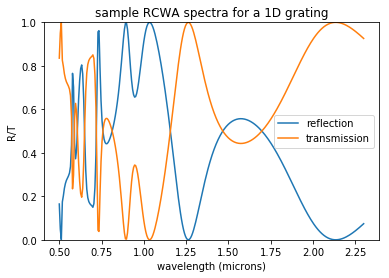

In [121]:

plt.figure();
plt.plot(wavelength_scan, np.abs(spectra));
plt.plot(wavelength_scan, np.abs(spectra_T))
plt.xlabel('wavelength (microns)')
plt.ylabel('R/T')
plt.title('sample RCWA spectra for a 1D grating')
plt.legend(['reflection', 'transmission'])
# plt.axhline(((3.48-1)/(3.48+1))**2,xmin=0, xmax = max(wavelength_scan))
# plt.axhline(((3.48-1)/(3.48+1)),xmin=0, xmax = max(wavelength_scan), color='r')
plt.ylim([0,1])
plt.show()

In [114]:
## comparison to the 2nd order, stable formulation
# also the first real test of the function

## A Curious Numerical Observation
Something which plagues the first order formulation is that if we take a number,say -5. Taking the square root would give $-\sqrt{5}$. however, if we add in a tiny COMPLEX perturbation of negative sign, we can completely flip the sign. This must be a numerical artifact of numerical imprecision that happens in the stable formulation when we take the square root, but WHY is the 2nd order formulation still stable?


In [115]:
import math
a = -5 - j*1e-16;
print(cmath.sqrt(a))

(2.2360679774997896e-17-2.23606797749979j)


## ONLY FIRST ORDER RAW CODE

In [157]:
## alternate construction of 1D convolution matrix
spectra = list();
spectra_T = list();
I = np.identity(2 * num_ord + 1)
PQ = 2*num_ord+1;
zeros = np.zeros((PQ, PQ))
# E is now the convolution of fourier amplitudes
wavelength_scan = np.linspace(0.5,2.3,20)

for wvlen in wavelength_scan:
    j = cmath.sqrt(-1);
    lam0 = wvlen;     k0 = 2 * np.pi / lam0; #free space wavelength in SI units
    print('wavelength: ' + str(wvlen));
    ## =====================STRUCTURE======================##

    ## Region I: reflected region (half space)
    n1 = 1;#cmath.sqrt(-1)*1e-12; #apparently small complex perturbations are bad in Region 1, these shouldn't be necessary

    ## Region 2; transmitted region
    n2 = 1;

    #from the kx_components given the indices and wvln
    kx_array = k0*(n1*np.sin(theta) + indices*(lam0 / lattice_constant)); #0 is one of them, k0*lam0 = 2*pi
    k_xi = kx_array;
    ## IMPLEMENT SCALING: these are the fourier orders of the x-direction decomposition.
    KX = np.diag(kx_array/k0);
    KX2 = np.diag(np.power((k_xi/k0),2)); #singular since we have a n=0, m= 0 order and incidence is normal
    #print(KX2)
    KZ2 = ((n1)**2 - np.diag(KX2)).astype('complex');
    KZ = np.sqrt(KZ2)
#     print('KZ2: '+str(KZ2)+': imag Kz: '+str(KZ))
#     KZ_mask = np.imag(KZ)<1e-2;
#     KZ_mask = np.expand_dims(KZ_mask, axis = 1)
#     print(KZ_mask.shape)
    
    ## construct matrix of Gamma^2 ('constant' term in ODE):
    A = KX2 - E; #conditioning of this matrix is not bad, A SHOULD BE SYMMETRIC
    #sum of a symmetric matrix and a diagonal matrix should be symmetric;
    AO = np.block([[zeros, I],[A, zeros]])
    beigenvals, bigW = LA.eig(AO);
    print('conditioning of big block: '+str(np.linalg.cond(AO)))
    ## SORTING IS REQUIRED
    sq_beigenvals = np.square(beigenvals);
    
    #try rounding...
    rounded_beigenvals = np.array([round(i,12) for i in beigenvals])
    #print(rounded_beigenvals)
    quadrant_sort = [1 if np.real(i)>=0 and np.imag(i)>=0 else 0 for i in rounded_beigenvals];
    #print(quadrant_sort)
    sorted_indices = np.nonzero(quadrant_sort)[0]
    vsorted_indices = [i for i in range(len(quadrant_sort)) if i not in sorted_indices]
    print(vsorted_indices)
    print(sorted_indices)
    #sorted_indices = np.argsort(np.real(rounded_beigenvals))
    sorted_eigenmodes = bigW[:,sorted_indices];
    Vsorted_eigenmodes = bigW[:, vsorted_indices];
    #print(sorted_eigenmodes)
    #adding real and imaginary parts seems to work...
    sorted_eigenvals = beigenvals[sorted_indices]
    Wp = sorted_eigenmodes[PQ:,0:PQ]
    V = Vsorted_eigenmodes[0:PQ, 0:PQ ]
    print(V.shape)

    eigenvals_wp = (sorted_eigenvals[0:PQ]);

    # when we calculate eigenvals, how do we know the eigenvals correspond to each particular fourier order?
    eigenvals, W = LA.eig(A); #A should be symmetric or hermitian
    #print('sorted eigenvals: '+str(sorted_eigenvals))

#     plt.plot(sq_beigenvals);
#     plt.plot(eigenvals)
#     plt.show()
    
    W = Wp;
    #we should be gauranteed that all eigenvals are REAL
    eigenvals = eigenvals.astype('complex');
    
    #real parts match, but the imaginaries don't
    Q = np.diag(eigenvals_wp);
    #plt.plot(sorted(np.abs(beigenvals)),'.-');
    colors = [(random.random(),random.random(),random.random()) for i in range(len(beigenvals))]
#     plt.subplot(141)
#     plt.plot(np.real(beigenvals), np.imag(beigenvals), '.'); plt.title('1st'); plt.ylim([-4,4])
#     plt.subplot(142)
#     plt.plot(np.real(eigenvals_wp), (np.imag(eigenvals_wp)), '.r', markersize = 10)
#     plt.plot(np.real(np.sqrt(eigenvals)), abs(np.imag(np.sqrt(eigenvals))), '.g', markersize = 5)

#     plt.ylim([-4,4])
#     plt.subplot(143);
#     plt.plot(np.real(eigenvals), np.imag(eigenvals), '.'); plt.title('2nd')
#     plt.ylim([-4,4])
#     plt.subplot(144)
#     plt.plot(np.real(np.sqrt(eigenvals)), np.imag(np.sqrt(eigenvals)), '.g'); plt.title('sqrt 2nd')
#     plt.ylim([-4,4])

#     plt.show();
#     plt.subplot(121)
#     for b in beigenvals:
#         plt.axhline(np.imag(b), color='r')
#     for b in np.sqrt(eigenvals):
#         plt.axhline(np.imag(b))

#     plt.plot((np.imag(np.diag(Q))),'.g-', markersize = 10)
#     plt.plot((np.imag(np.diag(Qn))), '.c-', markersize = 10)
#     plt.title(str((len(beigenvals), len(np.diag(Q)))))
    
#     plt.subplot(122)
    
#     for b in beigenvals:
#         plt.axhline(np.real(b), color = 'r')
#     for b in np.sqrt(eigenvals):
#         plt.axhline(np.real(b))
        
#     plt.plot((np.real(np.diag(Q))),'.g-', markersize = 10)
#     plt.title('real')

#     plt.plot((np.real(np.diag(Qn))), '.c-')
#     plt.show()


    V = W@Q; #H modes
#     plt.subplot(121)
#     plt.plot(np.real(Va))
#     plt.subplot(122)
#     plt.plot(np.real(V))
#     plt.show();
    
    ## THIS ENFORCES a PARTICULAR SIGN...
    X = np.diag(np.exp(-k0*np.diag(Q)*d)); #this is poorly conditioned because exponentiation
    ## pointwise exponentiation vs exponentiating a matrix

    ## observation: almost everything beyond this point is worse conditioned
    k_I = k0**2*(n1**2 - (k_xi/k0)**2);                 #k_z in reflected region k_I,zi
    k_II = k0**2*(n2**2 - (k_xi/k0)**2);   #k_z in transmitted region
    k_I = k_I.astype('complex'); k_I = np.sqrt(k_I);
    k_II = k_II.astype('complex'); k_II = np.sqrt(k_II);
    Y_I = np.diag(k_I/k0);
    Y_II = np.diag(k_II/k0);


    delta_i0 = np.zeros((len(kx_array),1));
    delta_i0[num_ord] = 1;
    n_delta_i0 = delta_i0*j*n1*np.cos(theta); #this is a VECTOR

    ## design auxiliary variables: SEE derivation in notebooks: RCWA_note.ipynb
    # we want to design the computation to avoid operating with X, particularly with inverses
    # since X is the worst conditioned thing

    Wi = np.linalg.inv(W);
    Vi = np.linalg.inv(V);
    Oi = 0.5*np.block([[Wi, Vi],[Wi, -Vi]])
    f = I;
    g = j*Y_II; #all matrices
    fg = np.concatenate((f,g),axis = 0)
    #ab = np.matmul(np.linalg.inv(O),fg);
    # ab = np.matmul(Oi, fg);
    # a = ab[0:PQ,:];
    # b = ab[PQ:,:];

    a = 0.5*(Wi+j*Vi@Y_II);
    b = 0.5*(Wi-j*Vi@Y_II);
    fbiX = np.matmul(np.linalg.inv(b),X)

    #altTerm = (a@X@X@b); #not well conditioned and I-altTermis is also poorly conditioned.
    #print(np.linalg.cond(I-np.linalg.inv(altTerm)))
    #print(np.linalg.cond(X@b)); #not well conditioned.

    term = X@a@fbiX; # THIS IS SHITTILY CONDITIONED
    # print((np.linalg.cond(X), np.linalg.cond(term)))
    # print(np.linalg.cond(I+term)); #but this is EXTREMELY WELL CONDITIONED.
    f = np.matmul(W, I+term);
    g = np.matmul(V,-I+term);
    T = np.linalg.inv(j*np.matmul(Y_I,f)+g);
    T = np.matmul(T,(np.matmul(j*Y_I,delta_i0)+n_delta_i0));
    R = np.matmul(f,T)-delta_i0;
    T = np.matmul(fbiX, T)

    ## calculate diffraction efficiencies
    #I would expect this number to be real...
    DE_ri = R*np.conj(R)*np.real(np.expand_dims(k_I,1))/(k0*n1*np.cos(theta));
    DE_ti = T*np.conj(T)*np.real(np.expand_dims(k_II,1))/(k0*n1*np.cos(theta));
    #print(np.sum(DE_ri))

    #print(np.sum(DE_ri))
    spectra.append(np.sum(DE_ri)); #spectra_T.append(T);
    spectra_T.append(np.sum(DE_ti))

wavelength: 0.5
conditioning of big block: 113.0809969549768
[0, 1, 4, 5, 8, 9, 12, 13, 14, 18, 22, 23, 26, 30, 31, 32, 33, 36, 37, 40, 41]
[ 2  3  6  7 10 11 15 16 17 19 20 21 24 25 27 28 29 34 35 38 39]
(21, 21)
wavelength: 0.5947368421052631
conditioning of big block: 314.1987638798421
[0, 1, 4, 5, 8, 9, 12, 13, 16, 17, 18, 21, 23, 24, 28, 29, 32, 33, 34, 38, 39]
[ 2  3  6  7 10 11 14 15 19 20 22 25 26 27 30 31 35 36 37 40 41]
(21, 21)
wavelength: 0.6894736842105262
conditioning of big block: 326.64766202236063
[2, 3, 6, 7, 10, 11, 14, 15, 21, 22, 23, 24, 25, 26, 30, 31, 34, 35, 36, 40, 41]
[ 0  1  4  5  8  9 12 13 16 17 18 19 20 27 28 29 32 33 37 38 39]
(21, 21)
wavelength: 0.7842105263157895
conditioning of big block: 175.54605652984324
[0, 1, 4, 5, 8, 9, 12, 13, 16, 17, 18, 19, 25, 29, 32, 33, 34, 35, 37, 38, 39]
[ 2  3  6  7 10 11 14 15 20 21 22 23 24 26 27 28 30 31 36 40 41]
(21, 21)
wavelength: 0.8789473684210526
conditioning of big block: 319.51992816229966
[2, 3, 6, 7, 10, 1

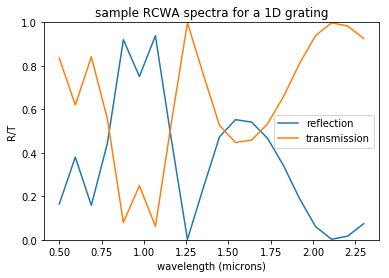

In [158]:
plt.figure();
plt.plot(wavelength_scan, np.abs(spectra), '-', markersize = 10);
plt.plot(wavelength_scan, np.abs(spectra_T), '-', markersize = 10)
plt.xlabel('wavelength (microns)')
plt.ylabel('R/T')
plt.title('sample RCWA spectra for a 1D grating')
plt.legend(['reflection', 'transmission'])
# plt.axhline(((3.48-1)/(3.48+1))**2,xmin=0, xmax = max(wavelength_scan))
# plt.axhline(((3.48-1)/(3.48+1)),xmin=0, xmax = max(wavelength_scan), color='r')
plt.ylim([0,1])
plt.show()

In [146]:
print(sq_beigenvals)
#we could try to numerically pair them (IF WE have some guarantee that they come in complex conjugate pairs), which I think is only valid
# for the TE case.

[1075.3145+8.3458e-14j 1075.305 +5.4572e-14j 1075.3145+2.6694e-14j
 1075.305 +1.7704e-14j  869.9639-2.9032e-14j  870.3438-1.1017e-13j
  869.9639+3.6598e-13j  870.3438+4.6165e-13j  686.7352-8.5336e-14j
  686.5023-1.5441e-13j  524.8468-1.1809e-14j  524.5176-1.4140e-13j
  686.7352-2.9469e-14j  686.5023-1.6492e-13j  384.0719-7.4836e-14j
  384.6079+5.8853e-14j  524.8468-5.6523e-14j  524.5176-9.0486e-14j
  384.0719-6.0925e-14j  384.6079+1.8811e-14j  265.5464+2.4561e-15j
  265.6359-5.0074e-14j  168.8714-9.1821e-15j  168.0086-2.2293e-14j
  265.5464+1.5522e-14j  265.6359+5.8174e-15j  168.8714-2.5878e-14j
  168.0086-8.6923e-15j   92.671 -4.6094e-14j   93.1292-1.2842e-14j
   38.2909-4.0661e-15j   39.6635-1.4006e-14j   -6.1403+1.5693e-14j
    7.8542+1.2932e-15j    6.1674+5.0691e-15j   -6.1403-1.2026e-14j
    7.8542+6.1556e-15j    6.1674+4.9650e-15j   92.671 -1.6372e-16j
   93.1292-1.2402e-14j   38.2909-2.1373e-14j   39.6635+8.6243e-15j]


## Complex eigenvalues of real matrices
Statement: eigenvalues of real matrices ALWAYS come in complex conjugate pairs.